Matt Cowell
Chaz Lyman
Michael Barth

# Final Project: Data Story and Modeling

### Research Question: What features of galaxies may be classified based on galaxy spectra?

####         Classifying galaxies is important to understanding how they have formed and evolved over time; galaxy classification helps us understand where galaxies came from and why they look the way they do. Furthermore, examining the differences in spectra between different galaxies helps tell us what gases galaxies are mainly composed of, which in turn can also advance the theory of galaxy evolution.
     
     
####         Our overall plan for data analysis is to get data from the SkyServer website with SQL. We will need various tables, including zoo2MainSpec, galSpecLine, and galSpecInfo. zoo2MainSpec is the galaxy classification data, half of which we will use to train our regression algorithm and half of which we will use to evaluate our algorithm’s performance. galSpecLine and galSpecInfo provide the spectral data for each galaxy. After getting these tables and merging them, we can clean our data by removing galaxies from our sample that people had trouble classifying and standardizing the spectral line data by controlling for the relative differences in overall galaxy brightness. After collecting and cleaning the data, we will then move onto classifying the sample of galaxies based on their characteristics (spiral or elliptical, disk or spherical, if they have bars, and how tightly wound the spiral arms are) using random forest regression and evaluate the effectiveness of the algorithm we used. 

## Data Description:
### Identifier:
#### SpecObjID is the unique identifier for each individual observation of each galaxy (the vast majority of agalxies have only one observation in SDSS, so this difference can be neglected).

### Predictors:
#### All columns ending in flux are emission lines. They represent the flux at a specific wavelength with the "continuum spectrum", or predicted non-emission-line flux, subtracted from the observed value. There are 19 emission lines total. Example: H_alpha_flux gives the flux for the H_alpha line emitted by Hydrogen gas.
#### v_disp and v_dispersion: The raw and normalized values, respectively, for the velocity dispersion of each galaxy. This is a measure of how much variability there is in the velocity of stars in a galaxy. 
#### lgm_tot_p50 and lgm_p50: The raw and normalized values, respectively, for the median of the log of the mass of the galaxy as measured in stellar masses. 
#### sfr_tot_p50 and sfr_p50: The raw and normalized values, respectively, for the median star formation rate in a galaxy, which was calculated based on the spectrum of the galaxy by a group of astronomers.

### Response Variables:
#### Each of the response variables represents the classification of a galaxy based on a certain type of feature. The numerical response variables (raw, non-normalized data) follows this format: question number, question, answer choice number, answer choice, "debiased". They are given as the proportion of the vote for that answer within the question. Debiased is an indicator of the preprocessing that has been done to the data to eliminate some selection bias (see the galaxy zoo 2 paper for details). 
#### The processed classifications are as follows, encapsulating the key results from the raw question data:
#### smooth_features has two categories: smooth or features/disk, describing the overall appearance of the galaxy
#### edge-on has two categories: yes or no. It describes whether a disk-shaped galaxy is edge on or facing us. This classification is only applied to features/disk galaxies.
#### bar has two categories: yes or no. It describes whether the given features/disk galaxy has a bar or not.
#### spiral has  two categories: yes or no. It describes whether the given features/disk galaxy has spiral arms or not.
#### bulge has 4 categories: no bulge, just noticeable, obvious, and dominant, which describe how large the bulge of the galaxy is with respect to the galaxy as a whole. 
#### odd has two categories: odd and normal. It describes whether the participant noticed anything odd about the galaxy.
#### odd_feature has 7 categories: ring, lens/arc, disturbed, irregular, merger, dust lane, and other. They specify which odd feature was observed for those observers who answeered yes to "odd".
#### shape has 4 categories: completely round, in-between, cigar-shaped, and not round. This describes the shape for smooth galaxies; not round is assigned to all other galaxies.
#### bulge_shape has 4 categories: rounded, boxy, no bulge, and not edge on. This describes the bulge shape for edge-on galaxies; all other galaxies are classified as not edge on.
#### armwind has 4 categories: tight, medium, loose, and not a spiral. This describes how much the spiral arms wind inward for a galaxy; all non spiral galaxies are classified as not a spiral.
#### armnum gives the number of spiral arms categorically: not a spiral, 1, 2, 3, 4, more than 4, and can't tell.

### Flow Chart of Galaxy Classification Used in Galaxy Zoo
Each colored block is a question; we have data for the proportion of responses for each response.

<img src=https://astrobites.org/wp-content/uploads/2013/08/Galaxy-Zoo-Flowchart-1024x766.png width="600">

In [1]:
import SciServer
from SciServer import Authentication, LoginPortal, Config, CasJobs, SkyQuery, SciDrive, SkyServer, Files, Jobs
import os;
import pandas as pd;
import sys;
import json;
from io import StringIO
from io import BytesIO
#from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### Login to database

Login information for my database:
username = mjb299
password = Celloguitar2

In [2]:
token1 = Authentication.login();

Enter SciServer user name: ········
Enter SciServer password: ········


### Copy of SQL query used to create original table (official_data0) in database

In [361]:
"""select s.specObjID, z.t01_smooth_or_features_a01_smooth_debiased, 
z.t01_smooth_or_features_a02_features_or_disk_debiased, z.t02_edgeon_a04_yes_debiased, 
z.t03_bar_a06_bar_debiased, t04_spiral_a08_spiral_debiased, 
z.t05_bulge_prominence_a10_no_bulge_debiased, 
z.t05_bulge_prominence_a11_just_noticeable_debiased, 
z.t05_bulge_prominence_a12_obvious_debiased, 
z.t05_bulge_prominence_a13_dominant_debiased, 
z.t06_odd_a14_yes_debiased, 
z.t07_rounded_a16_completely_round_debiased, 
z.t07_rounded_a17_in_between_debiased, 
z.t07_rounded_a18_cigar_shaped_debiased, 
z.t08_odd_feature_a19_ring_debiased, 
z.t08_odd_feature_a20_lens_or_arc_debiased, 
z.t08_odd_feature_a21_disturbed_debiased, 
z.t08_odd_feature_a22_irregular_debiased, 
z.t08_odd_feature_a23_other_debiased, 
z.t08_odd_feature_a24_merger_debiased, 
z.t08_odd_feature_a38_dust_lane_debiased, 
z.t09_bulge_shape_a25_rounded_debiased, 
z.t09_bulge_shape_a26_boxy_debiased, 
z.t09_bulge_shape_a27_no_bulge_debiased, 
z.t10_arms_winding_a28_tight_debiased, 
z.t10_arms_winding_a29_medium_debiased, 
z.t10_arms_winding_a30_loose_debiased, 
z.t11_arms_number_a31_1_debiased, 
z.t11_arms_number_a32_2_debiased, 
z.t11_arms_number_a33_3_debiased, 
z.t11_arms_number_a34_4_debiased, 
z.t11_arms_number_a36_more_than_4_debiased, 
z.t11_arms_number_a37_cant_tell_debiased, 
e.lgm_tot_p50, e.sfr_tot_p50, s.v_disp, l.oii_3726_flux, l.oii_3729_flux, 
l.neiii_3869_flux, l.h_delta_flux, l.h_gamma_flux, l.oiii_4363_flux, l.h_beta_flux, l.oiii_4959_flux, 
l.oiii_5007_flux, l.hei_5876_flux, l.oi_6300_flux, l.nii_6548_flux, l.h_alpha_flux, l.nii_6584_flux, 
l.sii_6717_flux, l.sii_6731_flux, l.ariii7135_flux, l.oii_flux, l.oiii_flux 
into mydb.official_data0 from dbo.galSpecInfo as s 
  join dbo.galSpecExtra as e on s.specObjID = e.specObjID 
  join dbo.galSpecLine as l on s.specObjID = l.specObjID 
  join dbo.zoo2MainSpecz as z on s.specObjID = z.specobjid 
where s.z between 0.03 and 0.04 and s.z_warning = 0 and e.lgm_tot_p50 between 9 and 11.5 
and s.v_disp_err > 0 and z.total_votes >100"""

'select s.specObjID, z.t01_smooth_or_features_a01_smooth_debiased, \nz.t01_smooth_or_features_a02_features_or_disk_debiased, z.t02_edgeon_a04_yes_debiased, \nz.t03_bar_a06_bar_debiased, t04_spiral_a08_spiral_debiased, \nz.t05_bulge_prominence_a10_no_bulge_debiased, \nz.t05_bulge_prominence_a11_just_noticeable_debiased, \nz.t05_bulge_prominence_a12_obvious_debiased, \nz.t05_bulge_prominence_a13_dominant_debiased, \nz.t06_odd_a14_yes_debiased, \nz.t07_rounded_a16_completely_round_debiased, \nz.t07_rounded_a17_in_between_debiased, \nz.t07_rounded_a18_cigar_shaped_debiased, \nz.t08_odd_feature_a19_ring_debiased, \nz.t08_odd_feature_a20_lens_or_arc_debiased, \nz.t08_odd_feature_a21_disturbed_debiased, \nz.t08_odd_feature_a22_irregular_debiased, \nz.t08_odd_feature_a23_other_debiased, \nz.t08_odd_feature_a24_merger_debiased, \nz.t08_odd_feature_a38_dust_lane_debiased, \nz.t09_bulge_shape_a25_rounded_debiased, \nz.t09_bulge_shape_a26_boxy_debiased, \nz.t09_bulge_shape_a27_no_bulge_debiased, \

### Obtaining data from database

In [3]:
official = CasJobs.executeQuery("select * from official_data0", "MyDB")

In [4]:
pd.set_option('display.max_columns', 100)

# Initial Analysis: First Look at the Data

### Histogram of Proportion of Votes Identifying a Galaxy as Smooth

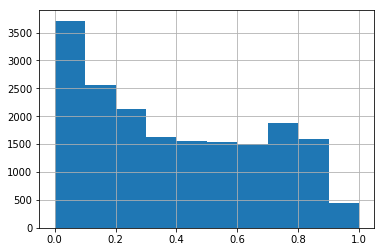

In [5]:
official['t01_smooth_or_features_a01_smooth_debiased'].hist()

In [6]:
official1 = official#[official.lgm_tot_p50 >9.5]

### Histogram of Galaxy Masses in log(stellar mass)

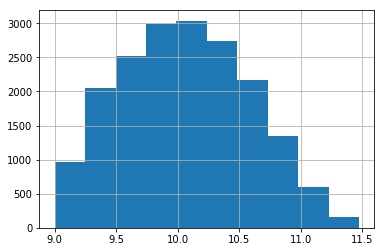

In [7]:
official1['lgm_tot_p50'].hist()

### Histogram of Proportion of Votes Classifying Galaxy as Smooth

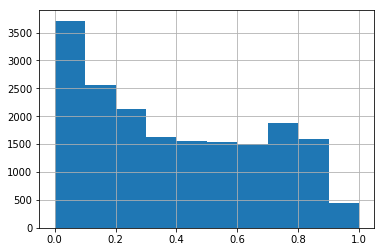

In [8]:
official1['t01_smooth_or_features_a01_smooth_debiased'].hist()

### Histogram of Proportion of Votes Classifying the Galaxy as a Spiral
#### Note that most galaxies were easy to classify as spiral or not spiral.

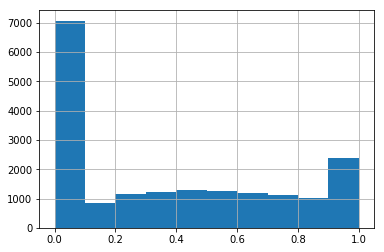

In [9]:
official1['t04_spiral_a08_spiral_debiased'].hist()

### Plot of "Spiral" Vote Proportion vs Galaxy Mass
#### On its own, galaxy mass seems to be a poor predictor of galaxy type. However, there does appear to be a slight downward trend.

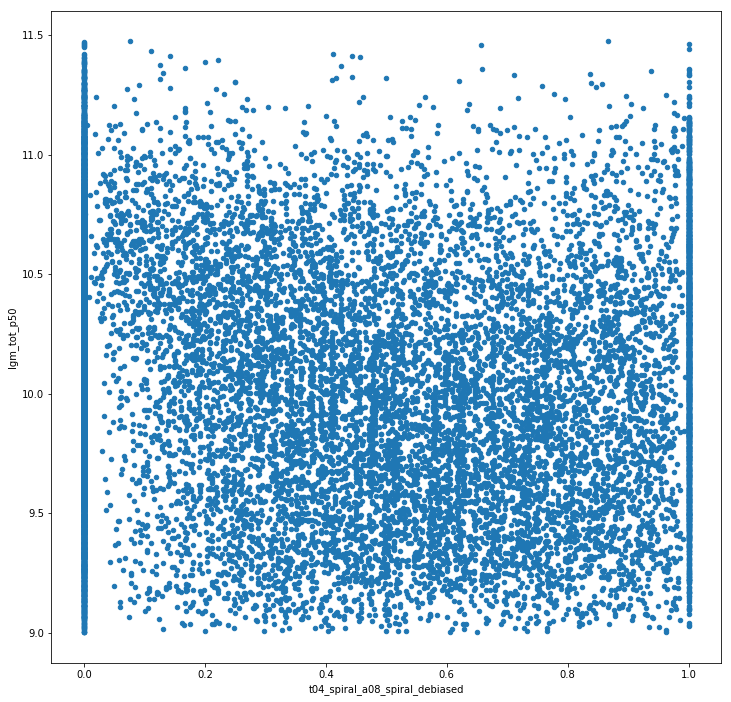

In [10]:
official1[['t04_spiral_a08_spiral_debiased', 'lgm_tot_p50']].plot.scatter(x = 't04_spiral_a08_spiral_debiased', y = 'lgm_tot_p50', figsize = (12, 12))

In [11]:
official1[['t04_spiral_a08_spiral_debiased', 'lgm_tot_p50']].corr()

,t04_spiral_a08_spiral_debiased,lgm_tot_p50
t04_spiral_a08_spiral_debiased,1.000000,-0.121026
lgm_tot_p50,-0.121026,1.000000


### Plot of Proportion of "Smooth" Votes vs Galaxy Mass
#### Again, mass proves to be a poor predictor.

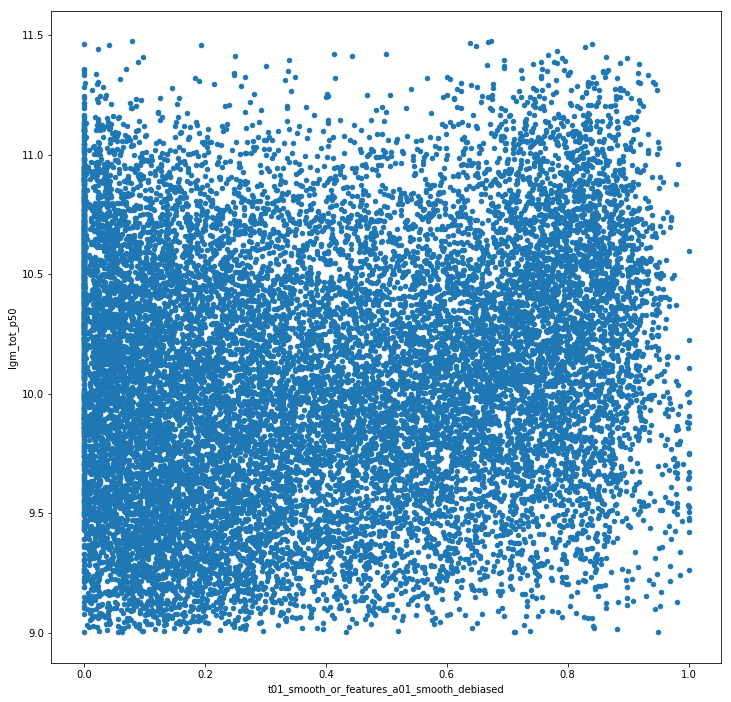

In [12]:
official1[['t01_smooth_or_features_a01_smooth_debiased', 'lgm_tot_p50']].plot.scatter(x = 't01_smooth_or_features_a01_smooth_debiased', y = 'lgm_tot_p50', figsize = (12, 12))

In [13]:
official1[['t01_smooth_or_features_a01_smooth_debiased', 'lgm_tot_p50']].corr()

,t01_smooth_or_features_a01_smooth_debiased,lgm_tot_p50
t01_smooth_or_features_a01_smooth_debiased,1.000000,0.156664
lgm_tot_p50,0.156664,1.000000


# Data Cleaning: Creating Categorical Variables for Each Question

####          The original response variables (answers to classification questions) came in the format of proportions of votes. We created categorical variables using the logic from the original questionnaire: different answers lead to different subsequent questions. In order to do this, we checked the answers to previous questions for all questions that came after the initial "smooth or features" question. Usually checking only the question immediately before was sufficient to make sure this galaxy was on the correct "track". For instance, if the galaxy was classified as mostly smooth and featureless, but a couple of voters thought they saw features, which they almost universally described as spiral arms, this galaxy would still be classified as a smooth galaxy as opposed to one with spiral features. This prevents a small minority of voters from heavily influencing questions "further down". The probability which we used to determine yes/no questions was usually 0.5, except in cases (such as question 6: odd features) where we figured the majority of voters could still miss a hard to see but significant detail, in which case we used 0.3 or 0.4. For questions with multiple choices, we used if statements to find the response with the highest proportion of answers.

### Question 1: Smooth or Features/Disk

In [14]:
official1['smooth_features'] = ""

def smoothfeat(row):
    if row["t01_smooth_or_features_a01_smooth_debiased"] > 0.5:
        val = "smooth"
    else:
        val = "features"
    return val

In [15]:
official1['smooth_features'] = official1.apply(smoothfeat, axis=1)

### Question 2: Edge-on or not

In [16]:
def edgeon(row):
    if row['t01_smooth_or_features_a02_features_or_disk_debiased'] < 0.3:
        val = "not edge-on"
    elif row['t02_edgeon_a04_yes_debiased'] > 0.5:
        val = "edge-on"
    else:
        val = "not edge-on"
    return val

In [17]:
official1['edge-on'] = ""
official1['edge-on'] = official1.apply(edgeon, axis=1)

### Question 3: Bar or not

In [18]:
def bar(row):
    if row["t01_smooth_or_features_a01_smooth_debiased"] > 0.5:
        val = "not discernable"
    elif row['edge-on'] == 'edge-on':
        val = "not discernable"
    elif row["t03_bar_a06_bar_debiased"] > 0.5:
        val = "bar"
    else:
        val = 'no bar'
    return val

In [19]:
official1['bar'] = ""
official1['bar'] = official1.apply(bar, axis=1)

### Question 4: Spiral or not

In [20]:
def spiral(row):
    if row['smooth_features'] == 'smooth':
        val = 'not a spiral'
    elif row['edge-on'] == 'edge-on':
        val = "edge-on"
    elif row['t04_spiral_a08_spiral_debiased'] > 0.5:
        val = "spiral"
    else:
        val = "not a spiral"
    return val

In [21]:
official1['spiral'] = ""
official1['spiral'] = official1.apply(spiral, axis=1)

### Question 5: Rating of bulge prominence

In [22]:
def bulgeprom(row):
    if row['t05_bulge_prominence_a10_no_bulge_debiased'] == 0 \
    and row['t05_bulge_prominence_a11_just_noticeable_debiased'] == 0 \
    and row['t05_bulge_prominence_a12_obvious_debiased'] == 0 \
    and row['t05_bulge_prominence_a13_dominant_debiased'] == 0:
        val = 'no bulge'
    elif row['smooth_features'] == 'smooth':
        val = 'smooth'
    elif row['edge-on'] == 'edge-on':
        val = "edge-on"
    elif row['t05_bulge_prominence_a10_no_bulge_debiased'] > row['t05_bulge_prominence_a11_just_noticeable_debiased']\
    and row['t05_bulge_prominence_a10_no_bulge_debiased'] > row['t05_bulge_prominence_a12_obvious_debiased'] \
    and row['t05_bulge_prominence_a10_no_bulge_debiased'] >row['t05_bulge_prominence_a13_dominant_debiased']:
        val = 'no bulge'
    elif row['t05_bulge_prominence_a11_just_noticeable_debiased'] > row['t05_bulge_prominence_a12_obvious_debiased'] \
    and row['t05_bulge_prominence_a11_just_noticeable_debiased'] >row['t05_bulge_prominence_a13_dominant_debiased']:
        val = 'just noticeable'
    elif row['t05_bulge_prominence_a12_obvious_debiased'] > row['t05_bulge_prominence_a13_dominant_debiased']:
        val = 'obvious'
    else:
        val = 'dominant'
    return val

In [23]:
official1['bulge']=""
official1['bulge']=official1.apply(bulgeprom, axis=1)

### Question 6: Odd or not

In [24]:
def odd(row):
    if row['t06_odd_a14_yes_debiased'] > 0.4:
        val = 'odd'
    else:
        val = 'normal'
    return val

In [25]:
official1['odd']=""
official1['odd']=official1.apply(odd, axis=1)

### Question 7: Shape of galaxy (smooth only)

In [26]:
def shape(row):
    if row['t01_smooth_or_features_a01_smooth_debiased'] < 0.5:
        val = 'not smooth'
    elif row['t07_rounded_a16_completely_round_debiased'] ==0 and row["t07_rounded_a17_in_between_debiased"] ==0 and \
    row['t07_rounded_a16_completely_round_debiased'] > row["t07_rounded_a17_in_between_debiased"] \
    and row['t07_rounded_a18_cigar_shaped_debiased'] == 0:
        val = 'not round'
    elif row['t07_rounded_a16_completely_round_debiased'] > row["t07_rounded_a17_in_between_debiased"] and row['t07_rounded_a16_completely_round_debiased'] > row['t07_rounded_a18_cigar_shaped_debiased']:
        val = 'completely round'
    elif row["t07_rounded_a17_in_between_debiased"] > row['t07_rounded_a18_cigar_shaped_debiased']:
        val = 'in between'
    else:
        val = 'cigar shaped'
    return val

In [27]:
official1['shape']=''
official1['shape']=official1.apply(shape, axis=1)

### Question 8: Odd features

In [28]:
def oddfeat(row):
    if row['odd'] == 'odd':
        if row['t08_odd_feature_a19_ring_debiased'] > 0.5:
            val = 'ring'
        if row['t08_odd_feature_a20_lens_or_arc_debiased'] > 0.5:
            val = 'lens or arc'
        if row['t08_odd_feature_a21_disturbed_debiased'] > 0.5:
            val = 'disturbed'
        if row['t08_odd_feature_a22_irregular_debiased'] > 0.5:
            val = 'irregular'
        if row['t08_odd_feature_a23_other_debiased'] > 0.5:
            val = 'other'
        if row['t08_odd_feature_a24_merger_debiased'] > 0.5:
            val = 'merger'
        if row['t08_odd_feature_a38_dust_lane_debiased'] > 0.5:
            val = 'dust lane'
        else:
            val = 'normal'
    else:
        val = 'normal'
    return val

In [29]:
official1['odd_feature'] = ""
official1['odd_feature'] = official1.apply(oddfeat, axis=1)

### Question 9: Bulge Shape (only visible for edge-on galaxies)

In [30]:
def bulgeshape(row):
    if row['edge-on'] == 'edge-on':
        if row['t09_bulge_shape_a25_rounded_debiased'] > row['t09_bulge_shape_a26_boxy_debiased']\
        and row['t09_bulge_shape_a25_rounded_debiased'] > row['t09_bulge_shape_a27_no_bulge_debiased']:
            val = 'rounded'
        elif row['t09_bulge_shape_a26_boxy_debiased'] > row['t09_bulge_shape_a27_no_bulge_debiased']:
            val = 'boxy'
        else:
            val = 'no bulge'
    else:
        val = "not edge on"
    return val


In [31]:
official1['bulge_shape'] = ''
official1['bulge_shape'] = official1.apply(bulgeshape, axis=1)

### Question 10: Winding of Spiral Arms

In [32]:
def armwind(row):
    if row['spiral'] == 'spiral':
        if row['t10_arms_winding_a28_tight_debiased'] > row['t10_arms_winding_a29_medium_debiased']\
        and row['t10_arms_winding_a28_tight_debiased'] > row['t10_arms_winding_a30_loose_debiased']:
            val = 'tight'
        elif row['t10_arms_winding_a29_medium_debiased'] > row['t10_arms_winding_a30_loose_debiased']:
            val = 'medium'
        else:
            val = 'loose'
    else:
        val = "not a spiral"
    return val

In [33]:
official1['spiral_arm'] =''
official1['spiral_arm'] = official1.apply(armwind, axis=1)

### Question 11: Number of spiral arms

In [34]:
def armnum(row):
    if row['spiral'] == 'spiral':
        if row['t11_arms_number_a31_1_debiased'] > row['t11_arms_number_a32_2_debiased']\
        and row['t11_arms_number_a31_1_debiased'] > row['t11_arms_number_a33_3_debiased']\
        and row['t11_arms_number_a31_1_debiased'] > row['t11_arms_number_a34_4_debiased']\
        and row['t11_arms_number_a31_1_debiased'] > row['t11_arms_number_a36_more_than_4_debiased']\
        and row['t11_arms_number_a31_1_debiased'] > row['t11_arms_number_a37_cant_tell_debiased']:
            val = '1'
        elif row['t11_arms_number_a32_2_debiased'] > row['t11_arms_number_a33_3_debiased']\
        and row['t11_arms_number_a32_2_debiased'] > row['t11_arms_number_a34_4_debiased']\
        and row['t11_arms_number_a32_2_debiased'] > row['t11_arms_number_a36_more_than_4_debiased']\
        and row['t11_arms_number_a32_2_debiased'] > row['t11_arms_number_a37_cant_tell_debiased']:
            val = '2'
        elif row['t11_arms_number_a33_3_debiased'] > row['t11_arms_number_a34_4_debiased']\
        and row['t11_arms_number_a33_3_debiased'] > row['t11_arms_number_a36_more_than_4_debiased']\
        and row['t11_arms_number_a33_3_debiased'] > row['t11_arms_number_a37_cant_tell_debiased']:
            val = '3'
        elif row['t11_arms_number_a34_4_debiased'] > row['t11_arms_number_a36_more_than_4_debiased']\
        and row['t11_arms_number_a34_4_debiased'] > row['t11_arms_number_a37_cant_tell_debiased']:
            val = '4'
        elif row['t11_arms_number_a36_more_than_4_debiased'] > row['t11_arms_number_a37_cant_tell_debiased']:
            val = ">4"
        else:
            val = 'cant tell'
    else:
        val = 'not a spiral'
    return val

In [35]:
official1['armnum']=''
official1['armnum'] = official1.apply(armnum, axis=1)

# Scaling Data

### We first needed to scale the fluxes within each row: since the overall brightness of a galaxy could affect the flux for each emission line, we scaled every row to eliminate this overall difference in average brightness. Due to the presence of outliers and a non-normal distribution within rows and columns, we used RobustScaler to accomplish this.

In [36]:
from sklearn import preprocessing as prep
df_scale = official1[['oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux',
                     'oiii_4363_flux', 'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 
                     'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
                    'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux']]

def rowscaler(row):
    scaler=prep.RobustScaler()
    row1 = row.values
    row1 = np.reshape(row1, (19,1))
    scaled_df = scaler.fit_transform(row1)
    scaled_df = np.reshape(scaled_df, (1, 19))
    return scaled_df


df_scaled = (df_scale.apply(rowscaler, axis=1))

In [37]:
finalclean = pd.DataFrame.from_records(df_scaled)
finalclean = finalclean[0].apply(pd.Series)

### We then scaled the flux columns so that the columns/features could be compared more easily.

In [38]:
scaler=prep.RobustScaler()
finalclean1 = pd.DataFrame(scaler.fit_transform(finalclean))

In [39]:
finalclean1.rename({0:'oii_3726_flux', 1:'oii_3729_flux', 2:'neiii_3869_flux', 3:'h_delta_flux', 4:'h_gamma_flux',
                     5:'oiii_4363_flux', 6:'h_beta_flux', 7:'oiii_4959_flux', 8:'oiii_5007_flux', 9:'hei_5876_flux', 
                     10:'oi_6300_flux', 11:'nii_6548_flux', 12:'h_alpha_flux', 13:'nii_6584_flux', 14:'sii_6717_flux',
                    15:'sii_6731_flux', 16:'ariii7135_flux', 17:'oii_flux', 18:'oiii_flux'}, axis = 'columns', inplace = True)

### Merging the scaled dataset into the original

In [40]:
official1.reset_index(drop=True, inplace = True)

In [41]:
final_data = finalclean1.join(official1[['specObjID',
 't01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp','smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum']])

## Removing sfr outliers
#### A small fraction of galaxies had extremely large (-10000) values for the star formation rate. Since most galaxies form stars at a similar rate and identifying the rare "starburst galaxy" with higher rates was not our goal, we removed these galaxies. We do not know if these values were in error or if they were extreme cases of "starburst galaxies", so this issue woud warrant further investigation.

In [42]:
final_data = final_data[final_data.sfr_tot_p50 > -2000]

## Scaling the other predictors
#### In adddition to the fluxes, we decided also should scale the velocity dispersion, star formation rate, and the log of the mass. We used the min_max scaler to do this, as the square root and log methods work poorly with negative values.

In [43]:
clean2 = final_data[["lgm_tot_p50", "sfr_tot_p50", "v_disp"]]
min_max_scaler = prep.MinMaxScaler()
clean2 = pd.DataFrame(min_max_scaler.fit_transform(clean2))

In [44]:
scaler=prep.RobustScaler()
clean2 = pd.DataFrame(scaler.fit_transform(clean2))

In [45]:
clean2.rename({0:"lgm_p50", 1:"sfr_p50", 2:"v_dispersion"}, axis = 'columns', inplace = True)

In [46]:
final_data.reset_index(drop=True, inplace = True)

In [47]:
final_data1 = final_data.join(clean2)

## Removing flux outliers
####  These outliers are likely due to observational error. For each flux, an initial and post-outlier-removal graph is displayed. If no outliers were found, there is only one graph.

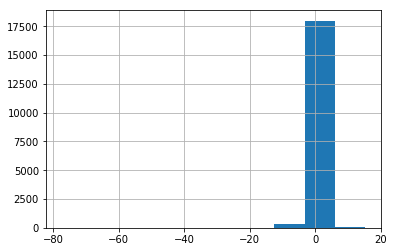

In [48]:
final_data1['oii_3726_flux'].hist()

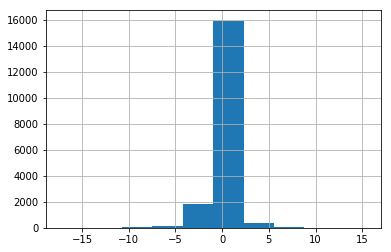

In [49]:
final_data1 = final_data1[final_data1.oii_3726_flux > -20]

final_data1['oii_3726_flux'].hist()

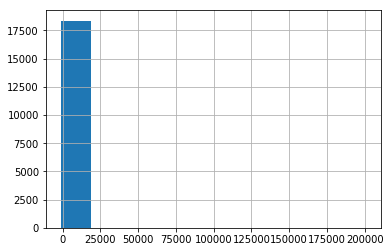

In [50]:
final_data1['oii_3729_flux'].hist()

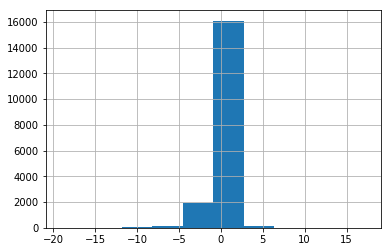

In [51]:
final_data1 = final_data1[final_data1.oii_3729_flux < 50000]
final_data1 = final_data1[final_data1.oii_3729_flux > -200]

final_data1['oii_3729_flux'].hist()

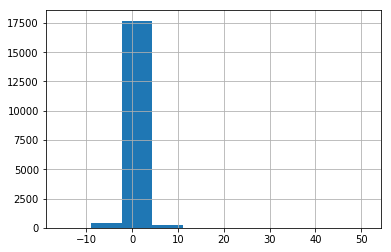

In [52]:
final_data1['neiii_3869_flux'].hist()

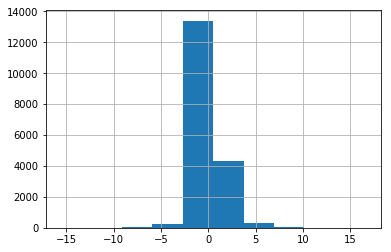

In [53]:
final_data1 = final_data1[final_data1.neiii_3869_flux < 20]

final_data1['neiii_3869_flux'].hist()

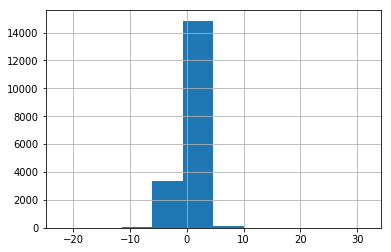

In [54]:
final_data1['h_delta_flux'].hist()

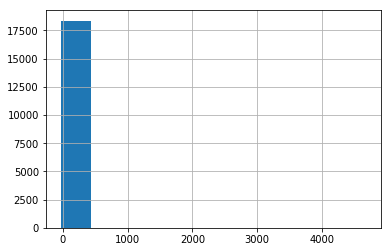

In [55]:
final_data1['h_gamma_flux'].hist()

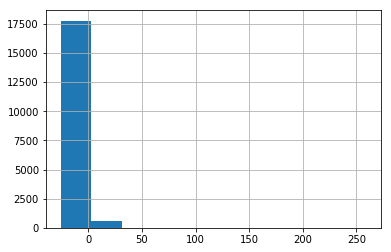

In [56]:
final_data1 = final_data1[final_data1.h_gamma_flux < 500]

final_data1['h_gamma_flux'].hist()

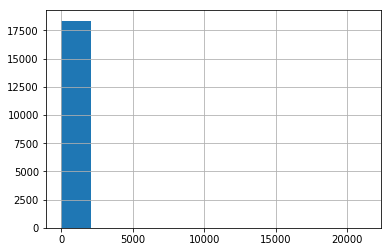

In [57]:
final_data1['oiii_4363_flux'].hist()

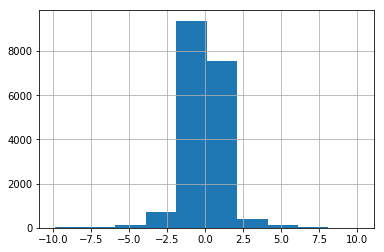

In [58]:
final_data1 = final_data1[final_data1.oiii_4363_flux < 5000]
final_data1 = final_data1[final_data1.oiii_4363_flux > -10]

final_data1['oiii_4363_flux'].hist()

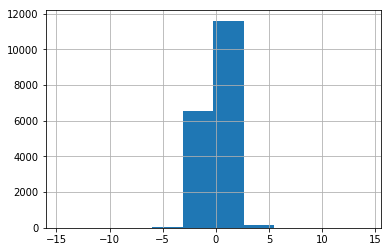

In [59]:
final_data1['h_beta_flux'].hist()

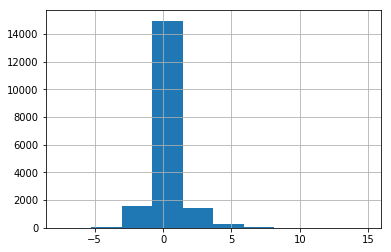

In [60]:
final_data1['oiii_4959_flux'].hist()

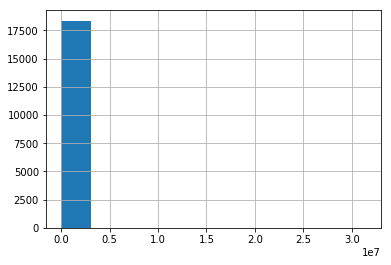

In [61]:
final_data1['oiii_5007_flux'].hist()

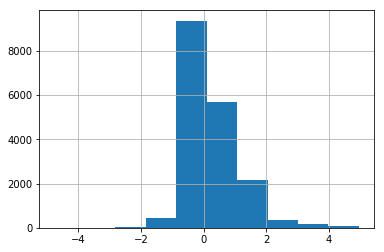

In [62]:
final_data1 = final_data1[final_data1.oiii_5007_flux < 5]
final_data1 = final_data1[final_data1.oiii_5007_flux > -10]

final_data1['oiii_5007_flux'].hist()

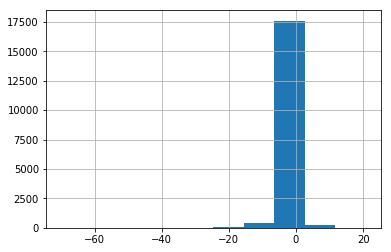

In [63]:
final_data1['hei_5876_flux'].hist()

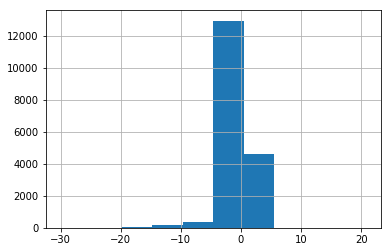

In [64]:
final_data1 = final_data1[final_data1.hei_5876_flux > -30]

final_data1['hei_5876_flux'].hist()

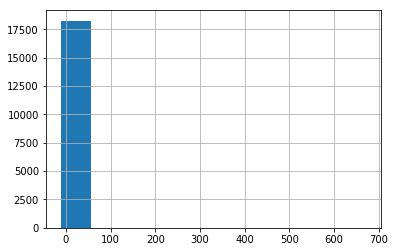

In [65]:
final_data1['oi_6300_flux'].hist()

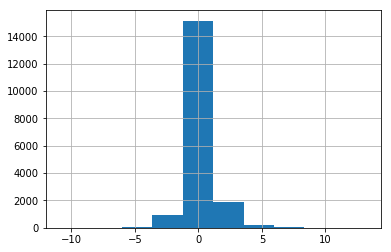

In [66]:
final_data1 = final_data1[final_data1.oi_6300_flux < 200]

final_data1['oi_6300_flux'].hist()

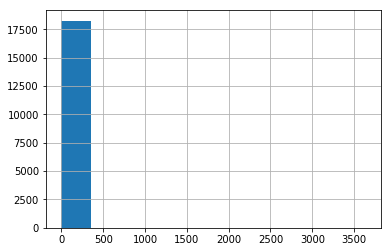

In [67]:
final_data1['nii_6548_flux'].hist()

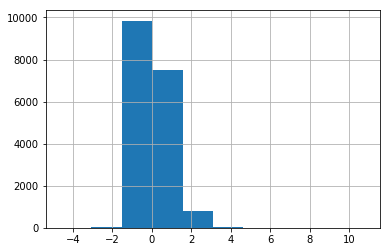

In [68]:
final_data1 = final_data1[final_data1.nii_6548_flux < 12]

final_data1['nii_6548_flux'].hist()

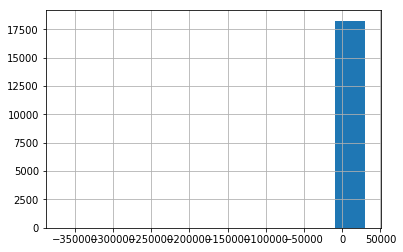

In [69]:
final_data1['h_alpha_flux'].hist()

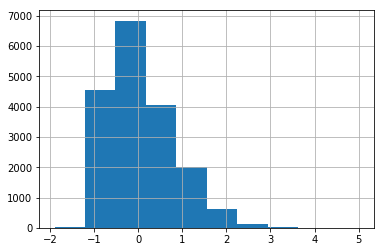

In [70]:
final_data1 = final_data1[final_data1.h_alpha_flux > -100000]
final_data1 = final_data1[final_data1.h_alpha_flux < 6]

final_data1['h_alpha_flux'].hist()

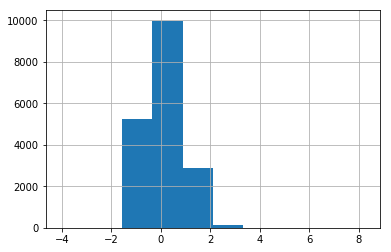

In [71]:
final_data1['nii_6584_flux'].hist()

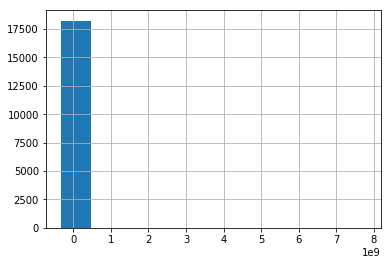

In [72]:
final_data1['sii_6717_flux'].hist()

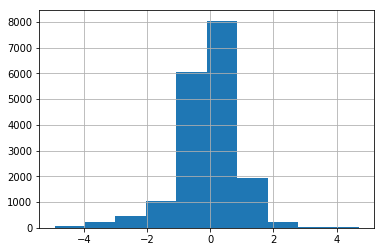

In [73]:
final_data1 = final_data1[final_data1.sii_6717_flux < 5]
final_data1 = final_data1[final_data1.sii_6717_flux > -5]

final_data1['sii_6717_flux'].hist()

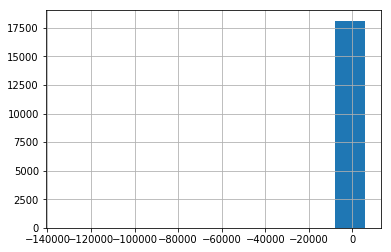

In [74]:
final_data1['sii_6731_flux'].hist()

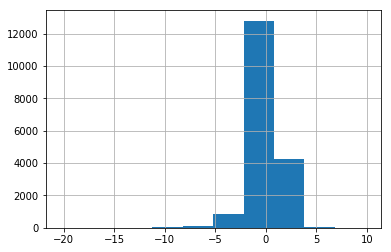

In [75]:
final_data1 = final_data1[final_data1.sii_6731_flux > -60000]
final_data1 = final_data1[final_data1.sii_6731_flux < 25]

final_data1['sii_6731_flux'].hist()

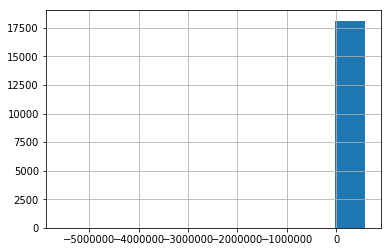

In [76]:
final_data1['ariii7135_flux'].hist()

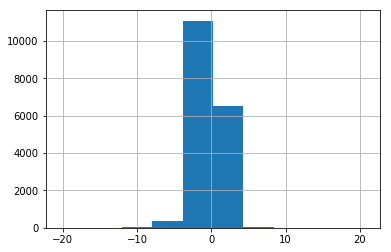

In [77]:
final_data1 = final_data1[final_data1.ariii7135_flux > -4000000]
final_data1 = final_data1[final_data1.ariii7135_flux < 3000]

final_data1['ariii7135_flux'].hist()

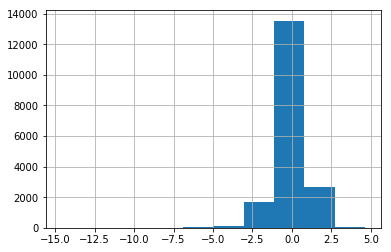

In [78]:
final_data1['oii_flux'].hist()

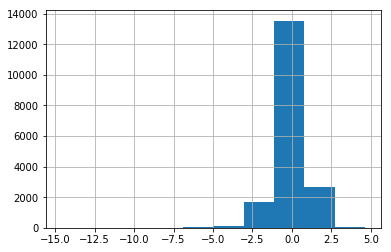

In [79]:
final_data1 = final_data1[final_data1.oii_flux > -15]

final_data1['oii_flux'].hist()

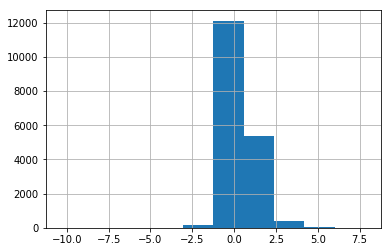

In [80]:
final_data1['oiii_flux'].hist()

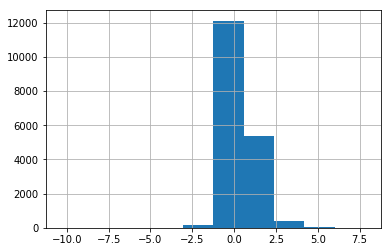

In [81]:
final_data1 = final_data1[final_data1.oiii_flux > -30]

final_data1['oiii_flux'].hist()

# Data Visualization

## Most Common Categorizations of Galaxies

In [82]:
final_data_groups = final_data1
xyz = final_data_groups.groupby(['smooth_features', 'edge-on', 'bar', 'spiral', 'bulge', 'odd',
                     'shape', 'odd_feature', 'bulge_shape', 'spiral_arm', 'armnum']).size().reset_index()

In [83]:
xyz.sort_values(by=0, ascending=False, inplace = True)
xyz.rename({0:"Count"}, axis = "columns")
xyz.head(10)

,smooth_features,edge-on,bar,spiral,bulge,odd,shape,odd_feature,bulge_shape,spiral_arm,armnum,0
246,smooth,not edge-on,not discernable,not a spiral,smooth,normal,in between,normal,not edge on,not a spiral,not a spiral,3079
245,smooth,not edge-on,not discernable,not a spiral,smooth,normal,completely round,normal,not edge on,not a spiral,not a spiral,1844
103,features,not edge-on,no bar,not a spiral,just noticeable,normal,not smooth,normal,not edge on,not a spiral,not a spiral,886
3,features,edge-on,not discernable,edge-on,edge-on,normal,not smooth,normal,rounded,not a spiral,not a spiral,828
2,features,edge-on,not discernable,edge-on,edge-on,normal,not smooth,normal,no bulge,not a spiral,not a spiral,822
145,features,not edge-on,no bar,spiral,just noticeable,normal,not smooth,normal,not edge on,tight,cant tell,803
105,features,not edge-on,no bar,not a spiral,just noticeable,odd,not smooth,normal,not edge on,not a spiral,not a spiral,541
112,features,not edge-on,no bar,not a spiral,obvious,odd,not smooth,normal,not edge on,not a spiral,not a spiral,456
11,features,edge-on,not discernable,edge-on,no bulge,normal,not smooth,normal,no bulge,not a spiral,not a spiral,442
244,smooth,not edge-on,not discernable,not a spiral,smooth,normal,cigar shaped,normal,not edge on,not a spiral,not a spiral,440


# Selected Graphs

## Number of galaxies that are smooth vs with features

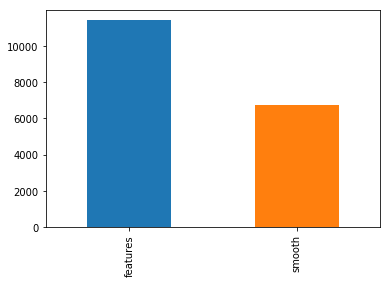

In [84]:
final_data1["smooth_features"].value_counts().sort_index().plot(kind='bar')

## Proportion of votes identifying galaxy as smooth vs star formation rate
#### Clear separation between smooth, low formation rate galaxies and high-feature, high formation galaxies

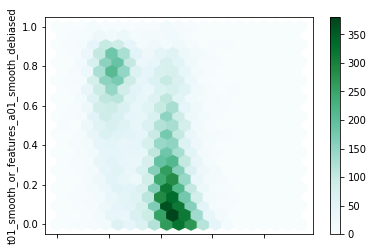

In [85]:
final_data1[["t01_smooth_or_features_a01_smooth_debiased", "sfr_p50"]].plot.hexbin(x = "sfr_p50", y= "t01_smooth_or_features_a01_smooth_debiased", gridsize=20)

## H_alpha flux versus star formation rate
#### Clear clustering into low flux and star formation vs high flux and star formation

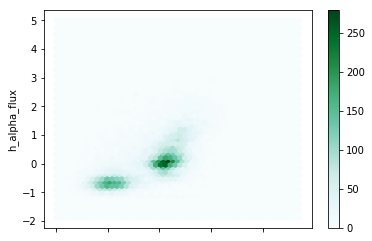

In [86]:
final_data1[["h_alpha_flux", "sfr_p50"]].plot.hexbin(x = "sfr_p50", y= "h_alpha_flux", gridsize=50)

## Features/smooth galaxies and emission lines
#### Emission lines alone can make classification a challenge, as below, with little separation between the groups

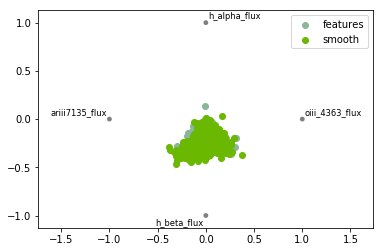

In [87]:
from pandas.plotting import radviz
radviz(final_data1[["smooth_features", "oiii_4363_flux", "h_alpha_flux", "ariii7135_flux", "h_beta_flux"]], "smooth_features")

## Mean values for smooth and high feature galaxies

In [88]:
smooth_group = final_data1.groupby(["smooth_features"]).mean()
smooth_group.head()

,oii_3726_flux,oii_3729_flux,neiii_3869_flux,h_delta_flux,h_gamma_flux,oiii_4363_flux,h_beta_flux,oiii_4959_flux,oiii_5007_flux,hei_5876_flux,oi_6300_flux,nii_6548_flux,h_alpha_flux,nii_6584_flux,sii_6717_flux,sii_6731_flux,ariii7135_flux,oii_flux,oiii_flux,specObjID,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a02_features_or_disk_debiased,t02_edgeon_a04_yes_debiased,t03_bar_a06_bar_debiased,t04_spiral_a08_spiral_debiased,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a13_dominant_debiased,t06_odd_a14_yes_debiased,t07_rounded_a16_completely_round_debiased,t07_rounded_a17_in_between_debiased,t07_rounded_a18_cigar_shaped_debiased,t08_odd_feature_a19_ring_debiased,t08_odd_feature_a20_lens_or_arc_debiased,t08_odd_feature_a21_disturbed_debiased,t08_odd_feature_a22_irregular_debiased,t08_odd_feature_a23_other_debiased,t08_odd_feature_a24_merger_debiased,t08_odd_feature_a38_dust_lane_debiased,t09_bulge_shape_a25_rounded_debiased,t09_bulge_shape_a26_boxy_debiased,t09_bulge_shape_a27_no_bulge_debiased,t10_arms_winding_a28_tight_debiased,t10_arms_winding_a29_medium_debiased,t10_arms_winding_a30_loose_debiased,t11_arms_number_a31_1_debiased,t11_arms_number_a32_2_debiased,t11_arms_number_a33_3_debiased,t11_arms_number_a34_4_debiased,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a37_cant_tell_debiased,lgm_tot_p50,sfr_tot_p50,v_disp,lgm_p50,sfr_p50,v_dispersion
smooth_features,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
features,0.025217,0.058106,-0.045039,-0.067777,-0.171106,-0.008953,0.097923,0.072308,0.163674,-0.076459,-0.035153,0.142905,0.257005,0.225083,0.136751,0.300045,-0.071491,0.133967,0.153405,1799287695941587456,0.200698,0.805174,0.262004,0.251230,0.495180,0.160280,0.429128,0.260488,0.054489,0.281826,0.165315,0.430523,0.334512,0.175428,0.048057,0.171805,0.212744,0.230921,0.074743,0.037784,0.393192,0.050946,0.237898,0.345360,0.300904,0.160289,0.055635,0.314886,0.052744,0.027725,0.027852,0.325751,9.990339,-0.385579,74.416840,-0.078308,0.033766,-0.033838
smooth,-0.110163,-0.368862,0.378751,0.249471,0.253218,-0.103839,-0.193542,0.435527,0.489114,-0.860638,0.298310,0.080867,-0.202540,-0.006093,-0.426753,-0.384359,-0.463833,-0.370942,0.482782,1757514560217370112,0.717629,0.290827,0.158436,0.138654,0.177315,0.105818,0.306252,0.390773,0.130063,0.160968,0.327340,0.516517,0.161245,0.114958,0.094842,0.143807,0.111227,0.309342,0.086493,0.012765,0.268077,0.029975,0.095802,0.186541,0.112360,0.057918,0.021909,0.091156,0.007403,0.005212,0.014066,0.217684,10.176824,-0.996248,111.278911,0.158332,-0.503490,0.514307


## Oiii flux for smooth and high feature galaxies
#### There is a clear difference between the two average fluxes, although based on the radviz above it may not be statistically significant.

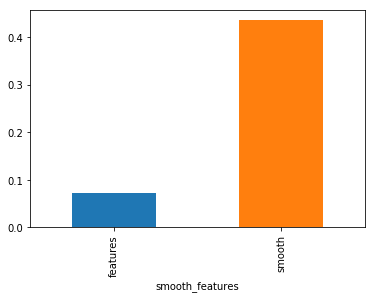

In [89]:
smooth_group["oiii_4959_flux"].plot(kind = "bar")

## He_i flux for smooth vs high feature galaxies
#### There is a clear difference between the two average fluxes, although based on the radviz above it may not be statistically significant.

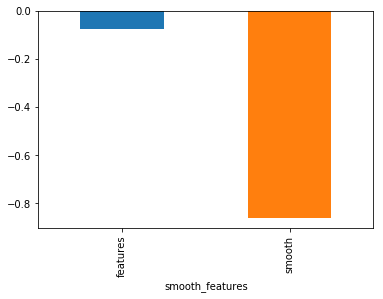

In [90]:
smooth_group["hei_5876_flux"].plot(kind = "bar")

# Investigating the number of spiral arms and the H_alpha flux

In [91]:
arm_group = final_data1.groupby(["armnum"]).mean()
arm_group.head(7)

,oii_3726_flux,oii_3729_flux,neiii_3869_flux,h_delta_flux,h_gamma_flux,oiii_4363_flux,h_beta_flux,oiii_4959_flux,oiii_5007_flux,hei_5876_flux,oi_6300_flux,nii_6548_flux,h_alpha_flux,nii_6584_flux,sii_6717_flux,sii_6731_flux,ariii7135_flux,oii_flux,oiii_flux,specObjID,t01_smooth_or_features_a01_smooth_debiased,t01_smooth_or_features_a02_features_or_disk_debiased,t02_edgeon_a04_yes_debiased,t03_bar_a06_bar_debiased,t04_spiral_a08_spiral_debiased,t05_bulge_prominence_a10_no_bulge_debiased,t05_bulge_prominence_a11_just_noticeable_debiased,t05_bulge_prominence_a12_obvious_debiased,t05_bulge_prominence_a13_dominant_debiased,t06_odd_a14_yes_debiased,t07_rounded_a16_completely_round_debiased,t07_rounded_a17_in_between_debiased,t07_rounded_a18_cigar_shaped_debiased,t08_odd_feature_a19_ring_debiased,t08_odd_feature_a20_lens_or_arc_debiased,t08_odd_feature_a21_disturbed_debiased,t08_odd_feature_a22_irregular_debiased,t08_odd_feature_a23_other_debiased,t08_odd_feature_a24_merger_debiased,t08_odd_feature_a38_dust_lane_debiased,t09_bulge_shape_a25_rounded_debiased,t09_bulge_shape_a26_boxy_debiased,t09_bulge_shape_a27_no_bulge_debiased,t10_arms_winding_a28_tight_debiased,t10_arms_winding_a29_medium_debiased,t10_arms_winding_a30_loose_debiased,t11_arms_number_a31_1_debiased,t11_arms_number_a32_2_debiased,t11_arms_number_a33_3_debiased,t11_arms_number_a34_4_debiased,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a37_cant_tell_debiased,lgm_tot_p50,sfr_tot_p50,v_disp,lgm_p50,sfr_p50,v_dispersion
armnum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.203402,0.274748,-0.060381,-0.047605,-0.094724,0.032925,0.124662,0.161624,0.293867,-0.040528,-0.079650,-0.046282,0.176689,0.052890,-0.042527,0.197307,0.063912,0.385080,0.288850,1807511584922153216,0.160684,0.828416,0.034963,0.220344,0.756167,0.160111,0.437274,0.269766,0.088196,0.452485,0.254587,0.631877,0.077573,0.156399,0.047156,0.211024,0.300077,0.159102,0.121344,0.003727,0.258204,0.035771,0.155453,0.401510,0.346867,0.253441,0.580030,0.183797,0.029820,0.007625,0.005092,0.189795,9.804672,-0.242631,70.050096,-0.313912,0.159530,-0.098773
2,0.042288,0.040778,-0.088975,-0.042714,-0.119336,-0.019800,0.245105,0.007431,0.095206,-0.049727,-0.075249,0.286041,0.376684,0.348951,0.139615,0.418523,-0.037745,0.145681,0.091011,1788404525496927744,0.098981,0.901123,0.052358,0.402303,0.836726,0.126287,0.481879,0.313227,0.058901,0.270159,0.177979,0.498719,0.124191,0.191478,0.048663,0.211281,0.224928,0.207816,0.085409,0.010909,0.409505,0.047106,0.144636,0.293579,0.426410,0.279394,0.042461,0.727551,0.054903,0.021354,0.011416,0.140248,10.016749,-0.255789,76.491534,-0.044795,0.147954,-0.002987
3,-0.138856,-0.018429,-0.088813,-0.036026,-0.054078,-0.108097,0.451272,-0.095772,-0.022696,-0.077888,-0.218298,0.431405,0.572003,0.512700,0.149915,0.363465,-0.126943,0.047509,-0.024721,1801348280284426496,0.057687,0.941561,0.024268,0.237020,0.901899,0.102546,0.532722,0.309530,0.033880,0.251959,0.237271,0.426410,0.016997,0.096059,0.047332,0.267544,0.280712,0.206707,0.085974,0.006312,0.345469,0.014756,0.107026,0.387087,0.468508,0.140016,0.018582,0.163393,0.496387,0.106881,0.045925,0.163275,10.112301,-0.116156,71.497652,0.076455,0.270801,-0.077247
4,-0.104968,-0.113899,-0.132466,-0.158522,-0.031239,-0.123958,0.473323,-0.050289,-0.034138,-0.130175,-0.162100,0.438935,0.564664,0.538645,0.175879,0.489844,-0.189242,0.001144,-0.031100,1792743529072136448,0.059469,0.942830,0.029123,0.218770,0.924019,0.098615,0.552066,0.293496,0.029937,0.203419,0.230167,0.331541,0.029620,0.101484,0.053130,0.258408,0.276722,0.207477,0.042793,0.005562,0.300168,0.030598,0.130732,0.437895,0.441139,0.118479,0.008864,0.105501,0.141302,0.438268,0.139490,0.160768,10.151354,-0.067690,72.143975,0.126013,0.313440,-0.067636
>4,-0.155476,-0.152477,-0.150633,0.159509,0.154357,-0.098390,0.530167,0.053504,-0.025658,-0.207847,-0.154678,0.545884,0.617491,0.607091,0.105477,0.153018,-0.219226,-0.107832,-0.003754,1860328618867827456,0.065490,0.933658,0.0235

## Number of arms vs H_alpha flux
#### The more arms a spiral has, the higher the H_alpha flux. Non-spirals have a negative H_alpha flux.

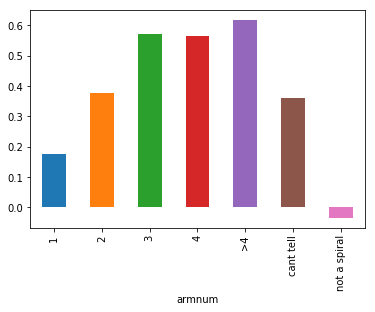

In [92]:
arm_group["h_alpha_flux"].plot(kind = "bar")

## Number of arms vs O_iii flux
#### The more arms a spiral has, the lower the O_iii flux. However, the lowest average O_iii flux belongs to non-spirals.

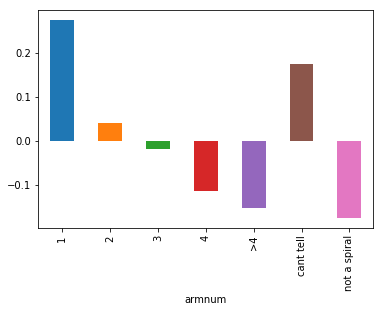

In [93]:
arm_group["oii_3729_flux"].plot(kind = "bar")

# Removing Irrelevant Data for Each Question to Speed Up Algorithms

#### Organizing data by question/response variable, removing irrelevant observations based on question sequence in Galaxy Zoo 2, and splitting data into our emission lines and the sfr value, which was calculated using another combination of emission lines.

In [94]:
final_data1.shape

(18123, 69)

In [95]:
smooth_final = final_data1

In [96]:
edgeon_final = final_data1

In [97]:
bar_final = final_data1[final_data1.bar != "not discernable"]

In [98]:
spiral_final = final_data1[final_data1.spiral != "edge-on"]

In [99]:
bulgeprom_final = final_data1[final_data1.bulge != "smooth"]
bulgeprom_final = bulgeprom_final[bulgeprom_final.bulge != "edge-on"]

In [100]:
odd_final = final_data1

In [101]:
shape_final = final_data1[final_data1["shape"] != "not smooth"]

In [102]:
oddfeatures_final = final_data1

In [103]:
bulgeshape_final = final_data1[final_data1.bulge_shape != "not edge-on"]

In [104]:
armwind_final = final_data1[final_data1.spiral_arm != "not a spiral"]

In [105]:
armnum_final = final_data1[final_data1.armnum != "not a spiral"]
armnum_final = armnum_final[armnum_final.armnum != "cant tell"]

In [106]:
smooth_final = smooth_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased','lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp','edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [107]:
edgeon_final = edgeon_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased', 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp', 'smooth_features',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [108]:
bar_final = bar_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased', 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp', 'smooth_features',
 'edge-on',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [109]:
spiral_final = spiral_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased', 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp', 'smooth_features',
 'edge-on',
 'bar',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [110]:
bulgeprom_final = bulgeprom_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased', 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp', 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [111]:
odd_final = odd_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased', 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp', 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [112]:
shape_final = shape_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp',
 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'odd_feature',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [113]:
oddfeatures_final = oddfeatures_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp',
 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'bulge_shape',
 'spiral_arm',
 'armnum'])

In [114]:
bulgeshape_final = bulgeshape_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp',
 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'spiral_arm',
 'armnum'])

In [115]:
armwind_final = armwind_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp',
 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'armnum'])

In [116]:
armnum_final = armnum_final.drop(columns = ['t01_smooth_or_features_a01_smooth_debiased',
 't01_smooth_or_features_a02_features_or_disk_debiased',
 't02_edgeon_a04_yes_debiased',
 't03_bar_a06_bar_debiased',
 't04_spiral_a08_spiral_debiased',
 't05_bulge_prominence_a10_no_bulge_debiased',
 't05_bulge_prominence_a11_just_noticeable_debiased',
 't05_bulge_prominence_a12_obvious_debiased',
 't05_bulge_prominence_a13_dominant_debiased',
 't06_odd_a14_yes_debiased',
 't07_rounded_a16_completely_round_debiased',
 't07_rounded_a17_in_between_debiased',
 't07_rounded_a18_cigar_shaped_debiased',
 't08_odd_feature_a19_ring_debiased',
 't08_odd_feature_a20_lens_or_arc_debiased',
 't08_odd_feature_a21_disturbed_debiased',
 't08_odd_feature_a22_irregular_debiased',
 't08_odd_feature_a23_other_debiased',
 't08_odd_feature_a24_merger_debiased',
 't08_odd_feature_a38_dust_lane_debiased',
 't09_bulge_shape_a25_rounded_debiased',
 't09_bulge_shape_a26_boxy_debiased',
 't09_bulge_shape_a27_no_bulge_debiased',
 't10_arms_winding_a28_tight_debiased',
 't10_arms_winding_a29_medium_debiased',
 't10_arms_winding_a30_loose_debiased',
 't11_arms_number_a31_1_debiased',
 't11_arms_number_a32_2_debiased',
 't11_arms_number_a33_3_debiased',
 't11_arms_number_a34_4_debiased',
 't11_arms_number_a36_more_than_4_debiased',
 't11_arms_number_a37_cant_tell_debiased',
 'lgm_tot_p50',
 'sfr_tot_p50',
 'v_disp',
 'smooth_features',
 'edge-on',
 'bar',
 'spiral',
 'bulge',
 'odd',
 'shape',
 'odd_feature',
 'bulge_shape',
 'spiral_arm'])

In [117]:
list(smooth_final)

['oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'specObjID',
 'smooth_features',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']

In [118]:
smooth_final_sfr = smooth_final[['specObjID',
 'smooth_features',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [119]:
edgeon_final_sfr = edgeon_final[['specObjID',
 'edge-on',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [120]:
bar_final_sfr = bar_final[['specObjID',
 'bar',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [121]:
spiral_final_sfr = spiral_final[['specObjID',
 'spiral',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [122]:
bulgeprom_final_sfr = bulgeprom_final[['specObjID',
 'bulge',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [123]:
odd_final_sfr = odd_final[['specObjID',
 'odd',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [124]:
shape_final_sfr = shape_final[['specObjID',
 'shape',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [125]:
oddfeatures_final_sfr = oddfeatures_final[['specObjID',
 'odd_feature',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [126]:
bulgeshape_final_sfr = bulgeshape_final[['specObjID',
 'bulge_shape',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [127]:
armwind_final_sfr = armwind_final[['specObjID',
 'spiral_arm',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

In [128]:
armnum_final_sfr = armnum_final[['specObjID',
 'armnum',
 'lgm_p50',
 'sfr_p50',
 'v_dispersion']]

# Running Classification Using Random Forest Classification

### Using the Star Formation Rate as the spectral component for classification of the number of spiral arms

In [129]:
X = armnum_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = armnum_final_sfr["armnum"]

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [131]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [132]:
y_pred_class = model.predict(X_test)

In [133]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.3722461  0.37797825 0.24977565]


In [134]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7586726998491704


### Using the emission line fluxes as the spectral component for the classification of the number of spiral arms

In [135]:
X = armnum_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = armnum_final_sfr["armnum"]

In [136]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [137]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [138]:
y_pred_class = model.predict(X_test)

In [139]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.07248341 0.05268155 0.04651686 0.01981866 0.03522435 0.04431789
 0.08379533 0.07202184 0.03487099 0.04420654 0.03545065 0.05510693
 0.03807058 0.03486816 0.04076058 0.06169285 0.04101545 0.04364247
 0.06283312 0.00899651 0.07162525]


In [140]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7586726998491704


In [141]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)

df_ypred["armnum"].value_counts()
df_ypred1[0].value_counts()

2    663
Name: 0, dtype: int64

### Using both

In [142]:
X = armnum_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = armnum_final_sfr["armnum"]

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [144]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [145]:
y_pred_class = model.predict(X_test)

In [146]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.08703173 0.12846748 0.04369134 0.02872436 0.03555295 0.0775101
 0.03449376 0.06326014 0.03849503 0.0254393  0.03546242 0.03341449
 0.0142434  0.03994352 0.06385292 0.04167813 0.0184214  0.06686361
 0.02420221 0.03710991 0.02736283 0.03477895]


In [147]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7586726998491704


### SFR, arm winding

In [148]:
X = armwind_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = armwind_final_sfr["spiral_arm"]

In [149]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [150]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [151]:
y_pred_class = model.predict(X_test)

In [152]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.48416096 0.24585556 0.26998347]


In [153]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.484149855907781


### Lines, Arm Winding

In [154]:
X = armwind_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = armwind_final_sfr["spiral_arm"]

In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [156]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [157]:
y_pred_class = model.predict(X_test)

In [158]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.03530737 0.05027278 0.03649348 0.0419845  0.0227058  0.01678133
 0.04816245 0.05059545 0.03138198 0.01742389 0.04916111 0.02141168
 0.10946451 0.03918368 0.14350602 0.04423185 0.06486511 0.0365984
 0.05444886 0.03699371 0.04902604]


In [159]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.49951969260326606


In [160]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(100)

,index,spiral_arm,0
0,4346,loose,medium
1,6958,medium,medium
2,8807,tight,tight
3,15509,medium,tight
4,6691,loose,tight
5,16181,loose,medium
6,16468,loose,loose
7,13960,tight,medium
8,8723,tight,tight
9,17462,tight,tight


### Arms Winding, Both

In [161]:
X = armwind_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = armwind_final_sfr["spiral_arm"]

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [163]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [164]:
y_pred_class = model.predict(X_test)

In [165]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.06469183 0.01793265 0.07927618 0.0402944  0.05231869 0.01961314
 0.04817312 0.02647358 0.04625382 0.04184318 0.03329847 0.04815743
 0.02845914 0.0509051  0.02179201 0.16556315 0.04198834 0.03845317
 0.04196319 0.04150099 0.02161053 0.02943788]


In [166]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5004803073967339


### Spiral, sfr

In [167]:
X = spiral_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = spiral_final_sfr["spiral"]

In [168]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [169]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [170]:
y_pred_class = model.predict(X_test)

In [171]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.23390732 0.53814392 0.22794876]


In [172]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7146111291897169


### Spiral, lines

In [173]:
X = spiral_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = spiral_final["spiral"]

In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [175]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=12)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [176]:
y_pred_class = model.predict(X_test)

In [177]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.06911419 0.03058709 0.0380244  0.03199887 0.03535397 0.02956957
 0.02266087 0.03765337 0.05565234 0.0619019  0.03048982 0.03413199
 0.03501077 0.15423767 0.05497081 0.06486735 0.04203804 0.02675863
 0.04679653 0.04538102 0.05280081]


In [178]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7116823950536935


In [179]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

,index,spiral,0
0,7528,spiral,spiral
1,18163,not a spiral,spiral
2,11442,spiral,spiral
3,1842,not a spiral,spiral
4,4022,not a spiral,not a spiral
5,14196,not a spiral,not a spiral
6,7052,spiral,not a spiral
7,12793,not a spiral,not a spiral
8,9146,not a spiral,not a spiral
9,16809,not a spiral,not a spiral


### Spiral, Both

In [180]:
X = spiral_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = spiral_final_sfr["spiral"]

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [182]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [183]:
y_pred_class = model.predict(X_test)

In [184]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.04715708 0.49226097 0.01112594 0.01223211 0.00657379 0.00856901
 0.00830192 0.00491634 0.05706437 0.01153604 0.01327851 0.00315181
 0.00365103 0.01776692 0.09778595 0.03771966 0.01997844 0.03355372
 0.00321026 0.07332016 0.01468818 0.02215779]


In [185]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7113569801496908


### Smooth/features, sfr

In [186]:
X = smooth_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = smooth_final_sfr["smooth_features"]

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [188]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [189]:
y_pred_class = model.predict(X_test)

In [190]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.2019332  0.51328104 0.28478576]


In [191]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7453793103448276


### Smooth/Features, Lines

In [192]:
X = smooth_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = smooth_final["smooth_features"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [193]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=12)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [194]:
y_pred_class = model.predict(X_test)

In [195]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.07021763 0.02250679 0.03797891 0.02851847 0.03024107 0.03037774
 0.0273919  0.0387979  0.03075347 0.0384724  0.03818484 0.05481456
 0.04098219 0.16491924 0.06558331 0.07900868 0.04658667 0.02002659
 0.04412486 0.02334166 0.06717112]


In [196]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7475862068965518


In [197]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

,index,smooth_features,0
0,628,smooth,smooth
1,9016,features,features
2,9916,smooth,smooth
3,3570,smooth,features
4,13890,features,features
5,2914,smooth,features
6,14637,smooth,smooth
7,18175,features,features
8,7561,smooth,features
9,7575,features,smooth


### Smooth/features, Both

In [198]:
X = smooth_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = smooth_final["smooth_features"]

In [199]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [200]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=12)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [201]:
y_pred_class = model.predict(X_test)

In [202]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.04961487 0.28007154 0.01917332 0.02036204 0.01871154 0.02550293
 0.02563846 0.02388821 0.02825458 0.0228649  0.02089124 0.03391503
 0.02254404 0.0321479  0.08893993 0.04322852 0.03451587 0.05352389
 0.01771596 0.06940787 0.02545184 0.04363552]


In [203]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7544827586206897


### Bar, sfr

In [204]:
X = bar_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = bar_final_sfr["bar"]

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [206]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [207]:
y_pred_class = model.predict(X_test)

In [208]:
df_Xtest = pd.DataFrame(X_test)
df_Xtest.head(20)

,lgm_p50,sfr_p50,v_dispersion
9161,-0.126852,-0.056259,-0.439101
14411,0.425873,0.143432,0.563211
4112,0.188846,-1.453966,0.370188
15946,-0.454509,0.108094,-0.528956
7158,-0.170909,0.323345,-0.313473
8283,0.067686,0.533088,-0.509766
11642,-0.093283,-0.547036,-0.422547
9407,0.286885,0.556299,-0.103424
188,-0.859626,-0.568745,-1.140430
5234,-0.082426,0.370614,0.097450


In [209]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.3401833  0.34645173 0.31336497]


In [210]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7771990740740741


### Bar, lines

In [211]:
X = bar_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bar_final["bar"]

In [212]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [213]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=12)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [214]:
y_pred_class = model.predict(X_test)

In [215]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.05551587 0.03983753 0.04973769 0.0398708  0.03993757 0.04894503
 0.03880349 0.05743669 0.04414767 0.04003681 0.04287004 0.04771932
 0.0529475  0.06703819 0.05130382 0.04428624 0.03780052 0.04219862
 0.06023843 0.03863825 0.06068993]


In [216]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7806712962962963


In [217]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_new = df_ypred2[df_ypred2[0] != "no bar"]
df_new.head(20)

,index,bar,0
42,7897,bar,bar
45,13320,no bar,bar
56,13225,no bar,bar
105,16688,no bar,bar
108,8991,no bar,bar
137,14463,bar,bar
140,7468,bar,bar
141,8813,no bar,bar
198,12922,bar,bar
235,158,bar,bar


### Bar, Both

In [218]:
X = bar_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bar_final_sfr["bar"]

In [219]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [220]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [221]:
y_pred_class = model.predict(X_test)

In [222]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.09101847 0.17621721 0.03551361 0.03908467 0.01732794 0.04657474
 0.02523947 0.02579071 0.05690812 0.0226291  0.0207518  0.02005738
 0.01540862 0.04493806 0.05723117 0.06360923 0.02847681 0.03116203
 0.02101378 0.07674712 0.01559735 0.06870259]


In [223]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.7789351851851852


### SFR, Odd

In [224]:
X = odd_final_sfr[['lgm_p50', 'sfr_p50', 'v_dispersion']]
y = odd_final_sfr['odd']

In [225]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [226]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [227]:
y_pred_class = model.predict(X_test)

In [228]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.55286592 0.27779271 0.16934137]


In [229]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8082758620689655


### Lines, Odd

In [230]:
X = odd_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = odd_final_sfr["odd"]

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [232]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [233]:
y_pred_class = model.predict(X_test)

In [234]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.1403625  0.08953851 0.05102062 0.01524282 0.04690116 0.03180975
 0.04354648 0.03571172 0.02486043 0.00988492 0.03346787 0.01111757
 0.11993921 0.02755032 0.06386615 0.03303377 0.02731474 0.01798407
 0.09486994 0.02784357 0.05413391]


In [235]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8063448275862068


In [236]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(100)

,index,odd,0
0,628,normal,normal
1,9016,normal,normal
2,9916,odd,normal
3,3570,normal,normal
4,13890,normal,normal
5,2914,normal,normal
6,14637,normal,normal
7,18175,normal,normal
8,7561,normal,normal
9,7575,normal,normal


### Odd, Both

In [237]:
X = odd_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = odd_final_sfr["odd"]

In [238]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [239]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [240]:
y_pred_class = model.predict(X_test)

In [241]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.18983134 0.1194058  0.06118662 0.0682643  0.01704825 0.02605568
 0.03625262 0.01777722 0.03731418 0.02959686 0.02066966 0.01708876
 0.00626903 0.04566793 0.02972203 0.11937395 0.01276528 0.01748545
 0.00561039 0.0694891  0.03302112 0.02010446]


In [242]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8093793103448276


### SFR, Odd Features

In [243]:
X = oddfeatures_final_sfr[['lgm_p50', 'sfr_p50', 'v_dispersion']]
y = oddfeatures_final_sfr['odd_feature']

In [244]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [245]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [246]:
y_pred_class = model.predict(X_test)

In [247]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.4174437  0.26598165 0.31657465]


In [248]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.9972413793103448


In [249]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_new = df_ypred2[df_ypred2[0] != "normal"]
df_new.head(20)

,index,odd_feature,0


### Lines, Odd Features

In [250]:
X = oddfeatures_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = oddfeatures_final_sfr['odd_feature']

In [251]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [252]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=25)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [253]:
y_pred_class = model.predict(X_test)

In [254]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.07232556 0.04203744 0.05688608 0.03308059 0.04339715 0.06886928
 0.02780378 0.03040289 0.09657104 0.03245999 0.03994185 0.02989469
 0.03520935 0.06761733 0.04016072 0.08095895 0.03354661 0.03812123
 0.03896019 0.04445825 0.04729702]


In [255]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))


0.9972413793103448


In [256]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(100)

,index,odd_feature,0
0,628,normal,normal
1,9016,normal,normal
2,9916,normal,normal
3,3570,normal,normal
4,13890,normal,normal
5,2914,normal,normal
6,14637,normal,normal
7,18175,normal,normal
8,7561,normal,normal
9,7575,normal,normal


### Odd Features, Both

In [257]:
X = oddfeatures_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = oddfeatures_final_sfr["odd_feature"]

In [258]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [259]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=25)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [260]:
y_pred_class = model.predict(X_test)

In [261]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.05185675 0.07906812 0.03806668 0.06867723 0.07757558 0.052289
 0.04772164 0.02614431 0.03132674 0.02565084 0.04139084 0.03416288
 0.03943738 0.04482935 0.0375621  0.05253271 0.06551182 0.05674116
 0.03275432 0.03867086 0.02918993 0.02883976]


In [262]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.9972413793103448


### SFR, Shape

In [263]:
X = shape_final_sfr[['lgm_p50', 'sfr_p50', 'v_dispersion']]
y = shape_final_sfr['shape']

In [264]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [265]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [266]:
y_pred_class = model.predict(X_test)

In [267]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.39027116 0.32145198 0.28827686]


In [268]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5427509293680297


### Lines, Shape

In [269]:
X = shape_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = shape_final_sfr["shape"]

In [270]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [271]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [272]:
y_pred_class = model.predict(X_test)

In [273]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.06624955 0.04437531 0.03325077 0.02183179 0.04038809 0.0606826
 0.03386138 0.07834981 0.03490635 0.04370258 0.05274268 0.03387552
 0.03926124 0.10799814 0.03759803 0.08259218 0.04010388 0.02396095
 0.02829313 0.0357256  0.06025042]


In [274]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5449814126394052


In [275]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(100)

,index,shape,0
0,12539,completely round,in between
1,8530,completely round,in between
2,6332,in between,in between
3,16890,in between,in between
4,8489,in between,in between
5,6507,in between,in between
6,6793,in between,in between
7,14396,cigar shaped,in between
8,5505,in between,completely round
9,3274,completely round,in between


### Shape, Both

In [276]:
X = shape_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = shape_final_sfr["shape"]

In [277]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [278]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [279]:
y_pred_class = model.predict(X_test)

In [280]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.07857091 0.06060034 0.04555675 0.0666978  0.02776944 0.03075464
 0.0586212  0.027603   0.04173431 0.03791035 0.0175979  0.02260633
 0.02807543 0.04027017 0.05638057 0.04940671 0.09484838 0.05999564
 0.02589    0.01999051 0.04655155 0.06256807]


In [281]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.5412639405204461


### Bulge Prominance, Lines

In [282]:
X = bulgeprom_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bulgeprom_final["bulge"]

In [283]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [284]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=11)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [285]:
y_pred_class = model.predict(X_test)

In [286]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.09921764 0.03156796 0.03773885 0.02994888 0.0308702  0.03904828
 0.02930969 0.08268579 0.04111313 0.04119058 0.03375674 0.03430283
 0.04235378 0.06635834 0.0639337  0.05262205 0.03223228 0.03337278
 0.03984939 0.02765784 0.11086928]


In [287]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6246825799898426


In [288]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_new = df_ypred2[df_ypred2[0] != "no bulge"]
df_new.head(20)

,index,bulge,0
0,12472,just noticeable,just noticeable
2,11716,just noticeable,just noticeable
4,7554,no bulge,just noticeable
5,7052,obvious,obvious
6,12304,no bulge,just noticeable
7,4175,just noticeable,obvious
8,17265,obvious,just noticeable
9,1766,just noticeable,just noticeable
10,17397,no bulge,just noticeable
11,5673,no bulge,just noticeable


### Bulge Prominance, SFR

In [289]:
X = bulgeprom_final_sfr[['lgm_p50',
 'sfr_p50','v_dispersion']]
y = bulgeprom_final_sfr["bulge"]

In [290]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [291]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=11)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=11, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [292]:
y_pred_class = model.predict(X_test)

In [293]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.36646225 0.29704412 0.33649363]


In [294]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6038598273235145


In [295]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_new = df_ypred2[df_ypred2[0] != "no bulge"]
df_new.head(20)

,index,bulge,0
0,12472,just noticeable,just noticeable
1,16612,no bulge,just noticeable
2,11716,just noticeable,just noticeable
3,408,no bulge,just noticeable
4,7554,no bulge,just noticeable
5,7052,obvious,obvious
6,12304,no bulge,just noticeable
7,4175,just noticeable,obvious
8,17265,obvious,just noticeable
9,1766,just noticeable,just noticeable


### Bulge Prominence, Both

In [296]:
X = bulgeprom_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bulgeprom_final_sfr["bulge"]

In [297]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [298]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=9)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [299]:
y_pred_class = model.predict(X_test)

In [300]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6256983240223464


In [301]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_new = df_ypred2[df_ypred2[0] != "no bulge"]
df_new.head(20)

,index,bulge,0
0,12472,just noticeable,just noticeable
2,11716,just noticeable,just noticeable
4,7554,no bulge,just noticeable
5,7052,obvious,obvious
6,12304,no bulge,just noticeable
7,4175,just noticeable,obvious
8,17265,obvious,just noticeable
9,1766,just noticeable,just noticeable
10,17397,no bulge,just noticeable
11,5673,no bulge,just noticeable


### Edge-on, SFR

In [302]:
X = edgeon_final_sfr[['lgm_p50',
 'sfr_p50','v_dispersion']]
y = edgeon_final_sfr["edge-on"]

In [303]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [304]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=12)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [305]:
y_pred_class = model.predict(X_test)

In [306]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8171034482758621


In [307]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)


df_ypred2.head(20)

,index,edge-on,0
0,628,not edge-on,not edge-on
1,9016,not edge-on,not edge-on
2,9916,not edge-on,not edge-on
3,3570,not edge-on,not edge-on
4,13890,not edge-on,not edge-on
5,2914,not edge-on,not edge-on
6,14637,not edge-on,not edge-on
7,18175,not edge-on,not edge-on
8,7561,not edge-on,not edge-on
9,7575,not edge-on,not edge-on


In [309]:
df_ypred2[0].value_counts()

not edge-on    3567
edge-on          58
Name: 0, dtype: int64

### Edge-on, Lines

In [310]:
X = edgeon_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = edgeon_final["edge-on"]

In [311]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [312]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=50)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [313]:
y_pred_class = model.predict(X_test)

In [314]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8253793103448276


In [315]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

df_ypred2.head(20)

,index,edge-on,0
0,628,not edge-on,not edge-on
1,9016,not edge-on,not edge-on
2,9916,not edge-on,not edge-on
3,3570,not edge-on,not edge-on
4,13890,not edge-on,not edge-on
5,2914,not edge-on,not edge-on
6,14637,not edge-on,not edge-on
7,18175,not edge-on,not edge-on
8,7561,not edge-on,not edge-on
9,7575,not edge-on,not edge-on


In [316]:
df_ypred2[0].value_counts()

not edge-on    3197
edge-on         428
Name: 0, dtype: int64

### Edge-On, Both

In [317]:
X = edgeon_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = edgeon_final_sfr["edge-on"]

In [318]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [319]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=9)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [321]:
y_pred_class = model.predict(X_test)

In [322]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8408275862068966


In [323]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)




,index,edge-on,0
0,628,not edge-on,not edge-on
1,9016,not edge-on,not edge-on
2,9916,not edge-on,not edge-on
3,3570,not edge-on,not edge-on
4,13890,not edge-on,not edge-on
5,2914,not edge-on,not edge-on
6,14637,not edge-on,not edge-on
7,18175,not edge-on,not edge-on
8,7561,not edge-on,not edge-on
9,7575,not edge-on,not edge-on


### SFR, Bulge Shape

In [324]:
X = bulgeshape_final_sfr[['lgm_p50',
 'sfr_p50',
 'v_dispersion']]
y = bulgeshape_final_sfr["bulge_shape"]

In [325]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [326]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=4)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [327]:
y_pred_class = model.predict(X_test)

In [328]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'v_dispersion'], dtype='object')
[0.29888128 0.42549655 0.27562217]


In [329]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8176551724137932


### Lines, Bulge Shape

In [330]:
X = bulgeshape_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bulgeshape_final_sfr["bulge_shape"]

In [331]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [332]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [333]:
y_pred_class = model.predict(X_test)

In [334]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'oii_3726_flux', 'oii_3729_flux', 'neiii_3869_flux',
       'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux', 'h_beta_flux',
       'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux', 'oi_6300_flux',
       'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux', 'sii_6717_flux',
       'sii_6731_flux', 'ariii7135_flux', 'oii_flux', 'oiii_flux',
       'v_dispersion'],
      dtype='object')
[0.05179767 0.00706115 0.00707    0.01640295 0.02372654 0.09206031
 0.00177467 0.17434535 0.00384748 0.03215177 0.00919023 0.00939308
 0.01285656 0.13729112 0.03417613 0.22486572 0.02340942 0.01043397
 0.03300724 0.03333195 0.06180669]


In [335]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8176551724137932


In [336]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(100)

,index,bulge_shape,0
0,628,not edge on,not edge on
1,9016,not edge on,not edge on
2,9916,not edge on,not edge on
3,3570,not edge on,not edge on
4,13890,not edge on,not edge on
5,2914,not edge on,not edge on
6,14637,not edge on,not edge on
7,18175,not edge on,not edge on
8,7561,not edge on,not edge on
9,7575,not edge on,not edge on


### Bulge Shape, Both

In [337]:
X = bulgeshape_final[['lgm_p50', 'sfr_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = bulgeshape_final_sfr["bulge_shape"]

In [338]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [339]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=5)

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [340]:
y_pred_class = model.predict(X_test)

In [341]:
features = X.columns
print(features)
importances = model.feature_importances_
print(importances)

Index(['lgm_p50', 'sfr_p50', 'oii_3726_flux', 'oii_3729_flux',
       'neiii_3869_flux', 'h_delta_flux', 'h_gamma_flux', 'oiii_4363_flux',
       'h_beta_flux', 'oiii_4959_flux', 'oiii_5007_flux', 'hei_5876_flux',
       'oi_6300_flux', 'nii_6548_flux', 'h_alpha_flux', 'nii_6584_flux',
       'sii_6717_flux', 'sii_6731_flux', 'ariii7135_flux', 'oii_flux',
       'oiii_flux', 'v_dispersion'],
      dtype='object')
[0.07807429 0.09408349 0.01660417 0.0225471  0.0132051  0.04232611
 0.05553783 0.00495016 0.14824879 0.00170725 0.01746183 0.00467267
 0.02404432 0.03464639 0.05377537 0.01878279 0.19736049 0.06914797
 0.00726309 0.00795493 0.02177247 0.06583339]


In [343]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.8173793103448276


# Using SVM to classify spiral galaxies
#### We found that SVM underperformed Random Forest, even when tuned (ex. using class_weight)

In [344]:
X = spiral_final[['lgm_p50', 'oii_3726_flux',
 'oii_3729_flux',
 'neiii_3869_flux',
 'h_delta_flux',
 'h_gamma_flux',
 'oiii_4363_flux',
 'h_beta_flux',
 'oiii_4959_flux',
 'oiii_5007_flux',
 'hei_5876_flux',
 'oi_6300_flux',
 'nii_6548_flux',
 'h_alpha_flux',
 'nii_6584_flux',
 'sii_6717_flux',
 'sii_6731_flux',
 'ariii7135_flux',
 'oii_flux',
 'oiii_flux',
 'v_dispersion']]
y = spiral_final["spiral"]

In [345]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [346]:
from sklearn import svm

# instantiate model
model = svm.SVC(C = 100, class_weight = 'balanced') 

# fit model
model.fit(X_train, y_train)

/mnt/sda9/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [347]:
# make class predictions for the testing set
y_pred_class = model.predict(X_test)

In [348]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6729580214773837


In [349]:
df_ypred = pd.DataFrame(y_test)
df_ypred.reset_index(inplace = True)
df_ypred1 = pd.DataFrame(y_pred_class)
df_ypred2 = df_ypred.join(df_ypred1)
df_ypred2.head(200)

,index,spiral,0
0,7528,spiral,spiral
1,18163,not a spiral,spiral
2,11442,spiral,spiral
3,1842,not a spiral,spiral
4,4022,not a spiral,not a spiral
5,14196,not a spiral,spiral
6,7052,spiral,spiral
7,12793,not a spiral,spiral
8,9146,not a spiral,spiral
9,16809,not a spiral,spiral
